# Neural Network Regression with TensorFlow

There are many definitions for a regression problem but in our case, we're going to simplify it to be: predicting a number.

For example, you might want to:
- Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
- Predict the coordinates of a bounding box of an item in an image.
- Predict the cost of medical insurance for an individual given their demographics (age, sex, gender).

In this notebook, we're going to set the foundations for how you can take a sample of inputs (this is your data), build a neural network to discover patterns in those inputs and then make a prediction (in the form of a number) based on those inputs.

### What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a regression model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
- Creating custom data to view and fit
- Steps in modelling
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
- Evaluating a model
  - Visualizng the model
  - Looking at training curves
  - Compare predictions to ground truth
- Saving a model (so we can use it later)
- Loading a model

### Typical architecture of a regresison neural network

There are many different ways to write neural networks.
The following is a generic setup for taking in a collection of numbers, finding patterns in them and then outputting some kind of target number.


| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually ReLU |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | MSE (mean square error) or MAE (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

*Table 1: Typical architecture of a regression network. Source: Adapted from [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*


Note: A **hyperparameter** in machine learning is something a programmer can set themselves, where as a **parameter** usually describes something a model learns on its own.

In [1]:
import tensorflow as tf

2025-11-04 15:19:16.168603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-04 15:19:16.169191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-04 15:19:16.170061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-04 15:19:16.176551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Regression input shapes and output shapes

One of the most important concepts when working with neural networks are the input and output shapes.
These will differ depending on the problem you're working on.
Neural networks accept numbers and output numbers. These numbers are typically represented as tensors.

Before, we created data using NumPy arrays, but we could do the same with tensors.

In [2]:
# Example input and output shapes of a regression model
house_info = tf.constant(["bedroom", "bathroom", "garage"])
house_price = tf.constant([939700])
house_info, house_price

2025-11-04 15:19:20.017127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43604 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([939700], dtype=int32)>)

In [3]:
house_info.shape

TensorShape([3])

### Creating data to view and fit

Since we're working on a **regression problem** (predicting a number) let's create some linear data (a straight line) to model.

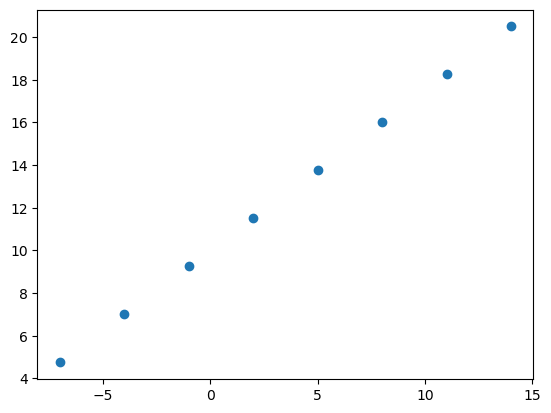

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Create features
X = np.array([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Create labels
y = 0.75*X + 10

# Visualize it
plt.scatter(X, y);

Our goal here will be to use `X` to predict `y`. So our **input** will be `X` and our **output** will be `y`.
Knowing this, what do you think our input and output shapes will be?

Let's take a look.

In [5]:
# Take a single example of X
input_shape = X.shape 

# Take a single example of y
output_shape = y.shape

input_shape, output_shape # these are both scalars (no shape)

((8,), (8,))

In [6]:
# Let's take a look at the single examples invidually
X, y

(array([-7., -4., -1.,  2.,  5.,  8., 11., 14.]),
 array([ 4.75,  7.  ,  9.25, 11.5 , 13.75, 16.  , 18.25, 20.5 ]))

Two of the things you'll spend the most time on when you work with neural networks: **making sure your input and outputs are in the correct shape**.

If it doesn't make sense now, we'll see plenty more examples later on (soon you'll notice the input and output shapes can be almost anything you can imagine).

### Steps in modelling with TensorFlow

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a models performance should be measured (loss/metrics) as well as defining how it should improve (optimizer). 
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`). 

Let's see these in action using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to build a model for our regression data. And then we'll step through each.

In [7]:
# Set random seed
tf.random.set_seed(42)

# Create a model using the Sequential API
model_0 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile the model
model_0.compile(loss=tf.keras.losses.mae, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.SGD(), # SGD is short for stochastic gradient descent
              metrics=["mae"])

# Fit the model
model_0.fit(tf.expand_dims(X, axis=-1), y, epochs=5)

Epoch 1/5
1/1 [==============================] - 0s 480ms/step - loss: 12.5202 - mae: 12.5202
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 12.3877 - mae: 12.3877
Epoch 3/5
1/1 [==============================] - 0s 3ms/step - loss: 12.2552 - mae: 12.2552
Epoch 4/5
1/1 [==============================] - 0s 3ms/step - loss: 12.1227 - mae: 12.1227
Epoch 5/5
1/1 [==============================] - 0s 3ms/step - loss: 11.9902 - mae: 11.9902


2025-11-04 15:19:21.089764: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4b313bd670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-04 15:19:21.089818: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-11-04 15:19:21.104480: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1762265961.165337 1961072 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


We've just trained our first model to figure out the patterns between our input and output data.

How do you think it went?

In [8]:
# Check out X and y
X, y

(array([-7., -4., -1.,  2.,  5.,  8., 11., 14.]),
 array([ 4.75,  7.  ,  9.25, 11.5 , 13.75, 16.  , 18.25, 20.5 ]))

What do you think the outcome should be if we passed our model an `X` value of 16.0?

In [9]:
# Make a prediction with the model
model_0.predict([16.0])

1/1 [==============================] - 0s 74ms/step


array([[3.3289063]], dtype=float32)

It didn't do well at all. It should've output something close to 22.0.

### Improving a model

How do you think you'd improve upon our current model?

If you guessed by tweaking some of the things we did above, you'd be correct.

To improve our model, we alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose a different optimization function or perhaps change the **learning rate** of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more **epochs** (leave it training for longer) or on more data (give the model more examples to learn from).

These are all hyperparamters that you as a programmer can change. It is important to mention, that you should not change too many hyperparameters at once (ideally just one), in order to see which effect they have on the model performance. However, since our first model was over-simplified, we will make a few tweaks at once.

In [10]:
# Set random seed
tf.random.set_seed(42)

# Create a model with more Layers
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compile model (same as above)
model_1.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# Fit model for 50 epochs
model_1.fit(tf.expand_dims(X, axis=-1), y, epochs=50)

Epoch 1/50
1/1 [==============================] - 0s 455ms/step - loss: 13.3189 - mae: 13.3189
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 12.8566 - mae: 12.8566
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 12.4006 - mae: 12.4006
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 11.9223 - mae: 11.9223
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 11.4405 - mae: 11.4405
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 10.9551 - mae: 10.9551
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 10.4628 - mae: 10.4628
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 9.9526 - mae: 9.9526
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 9.4338 - mae: 9.4338
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 8.9381 - mae: 8.9381
Epoch 11/50
1/1 [==============================] - 0s 3ms/step - loss: 8.

You might've noticed the loss value decrease from before (and keep decreasing as the number of epochs gets higher). 
What do you think this means for when we make a prediction with our model?

How about we try predict on 16.0 again?

In [11]:
# Remind ourselves of what X and y are
X, y

(array([-7., -4., -1.,  2.,  5.,  8., 11., 14.]),
 array([ 4.75,  7.  ,  9.25, 11.5 , 13.75, 16.  , 18.25, 20.5 ]))

In [12]:
# Try and predict what y would be if X was 16.0
model_1.predict([[16.0]]) # the right answer is 22.0 (y = 0.75*X + 10)

1/1 [==============================] - 0s 57ms/step


array([[26.79853]], dtype=float32)

Much better! 

We got closer this time. But we could still be better.

Now we've trained a model, how could we evaluate it?

### Evaluating a model 

A typical workflow you'll go through when building neural networks is:

```
Build a model -> evaluate it -> build (tweak) a model -> evaulate it -> build (tweak) a model -> evaluate it...
```

The tweaking comes from maybe not building a model from scratch but adjusting an existing one.

#### Visualize everything

When it comes to evaluation, you'll want to remember the words: "visualize, visualize, visualize." 

This is because you're probably better looking at graphs and images, than just numbers.

It's a good idea to visualize:
* **The data** - what data are you working with? What does it look like?
* **The model itself** - what does the architecture look like? What are the different shapes?
* **The training of a model** - how does a model perform while it learns?
* **The predictions of a model** - how do the predictions of a model line up against the ground truth (the original labels)?

Let's start by visualizing the model.

Before we begin, let's create a bigger dataset.

In [13]:
# Make a bigger dataset
X = np.arange(-100, 100, 4)
X

array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64,  -60,
        -56,  -52,  -48,  -44,  -40,  -36,  -32,  -28,  -24,  -20,  -16,
        -12,   -8,   -4,    0,    4,    8,   12,   16,   20,   24,   28,
         32,   36,   40,   44,   48,   52,   56,   60,   64,   68,   72,
         76,   80,   84,   88,   92,   96])

In [14]:
# Make labels for the dataset (adhering to the same pattern as before)
y = 0.75*X+10
y

array([-65., -62., -59., -56., -53., -50., -47., -44., -41., -38., -35.,
       -32., -29., -26., -23., -20., -17., -14., -11.,  -8.,  -5.,  -2.,
         1.,   4.,   7.,  10.,  13.,  16.,  19.,  22.,  25.,  28.,  31.,
        34.,  37.,  40.,  43.,  46.,  49.,  52.,  55.,  58.,  61.,  64.,
        67.,  70.,  73.,  76.,  79.,  82.])

### Split data into training/test set

One of the other most common and important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each set serves a specific purpose:
* **Training set** - the model learns from this data, which is typically 70-80% of the total data available (like the course materials you study during the semester).
* **Validation set** - the model gets tuned on this data, which is typically 10-15% of the total data available (like the practice exam you might have before the final exam).
* **Test set** - the model gets evaluated on this data to test what it has learned, it's typically 10-15% of the total data available (like the final exam you take at the end of the semester).

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.
We can create them by splitting our `X` and `y` arrays.

Note: When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it generalizes to unseen examples.

In [15]:
# Check how many samples we have
len(X)

50

In [16]:
# Split data into train and test sets
X_train = X[:40] # first 40 examples (80% of data)
y_train = y[:40]

X_test = X[40:] # last 10 examples (20% of data)
y_test = y[40:]

len(X_train), len(X_test)

(40, 10)

### Visualizing the data

Now we've got our training and test data, it's a good idea to visualize it.
Let's plot it with some nice colours to differentiate what's what.

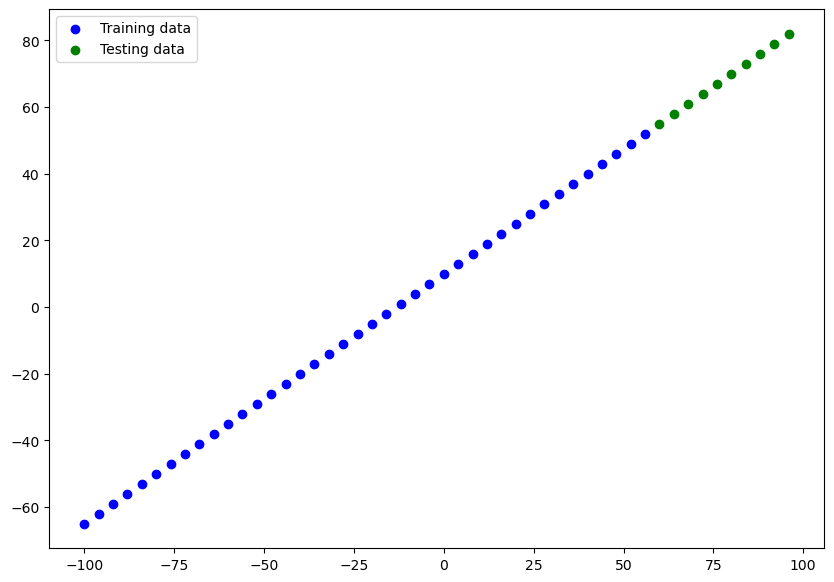

In [17]:
plt.figure(figsize=(10, 7))
# Plot training data in blue
plt.scatter(X_train, y_train, c='b', label='Training data')
# Plot test data in green
plt.scatter(X_test, y_test, c='g', label='Testing data')
# Show the legend
plt.legend();

With this graph in mind, what we'll be trying to do is build a model which learns the pattern in the blue dots (`X_train`) to draw the green dots (`X_test`).
It's your turn to build a model.Make the exact same one from before (the one we trained for longer).

In [18]:
# To do:
## Set random seed at 42

# Create a model (same as above) and call it model_2

# Compile model (same as above)

# Fit model with X_train, y_train (otherwise same as above)


#### Solution:

In [19]:
# Set random seed
tf.random.set_seed(42)

# Create a model with more Layers
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compile model (same as above)
model_2.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae", "mse"])

# Fit model for 50 epochs
model_2.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=50, verbose=1) # verbose=0 reduces the printed output

Epoch 1/50
2/2 [==============================] - 1s 7ms/step - loss: 21.7239 - mae: 21.7239 - mse: 985.3346
Epoch 2/50
2/2 [==============================] - 0s 3ms/step - loss: 21.9921 - mae: 21.9921 - mse: 796.1738
Epoch 3/50
2/2 [==============================] - 0s 3ms/step - loss: 24.8349 - mae: 24.8349 - mse: 842.8552
Epoch 4/50
2/2 [==============================] - 0s 3ms/step - loss: 9.0463 - mae: 9.0463 - mse: 132.8131
Epoch 5/50
2/2 [==============================] - 0s 3ms/step - loss: 4.3336 - mae: 4.3336 - mse: 27.7616
Epoch 6/50
2/2 [==============================] - 0s 3ms/step - loss: 5.9875 - mae: 5.9875 - mse: 47.0084
Epoch 7/50
2/2 [==============================] - 0s 3ms/step - loss: 9.0992 - mae: 9.0992 - mse: 148.0545
Epoch 8/50
2/2 [==============================] - 0s 3ms/step - loss: 6.4184 - mae: 6.4184 - mse: 49.5762
Epoch 9/50
2/2 [==============================] - 0s 3ms/step - loss: 16.3052 - mae: 16.3052 - mse: 509.3535
Epoch 10/50
2/2 [===============

### Visualizing the model

After you've built a model, you might want to take a look at it (especially if you haven't built many before).
You can take a look at the layers and shapes of your model by calling [`summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) on it.

Note: Visualizing a model is particularly helpful when you run into input and output shape mismatches.

In [20]:
# This will work after specifying the input shape
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                20        
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Calling `summary()` on our model shows us the layers it contains, the output shape and the number of parameters.
* **Total params** - total number of parameters in the model.
* **Trainable parameters** - these are the parameters (patterns) the model can update as it trains.
* **Non-trainable parameters** - these parameters aren't updated during training (this is typical when you bring in the already learned patterns from other models during transfer learning).

Alongside summary, you can also view a 2D plot of the model using [`plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

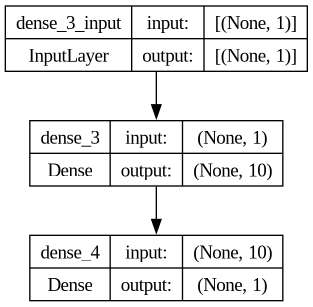

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(model_2, show_shapes=True)

In our case, the model we used only has an input and an output but visualizing more complicated models can be very helpful for debugging.

### Visualizing the predictions

Now we've got a trained model, let's visualize some predictions.
To visualize predictions, it's always a good idea to plot them against the ground truth labels.
Often you'll see this in the form of `y_test` vs. `y_pred` (ground truth vs. predictions).

First, we'll make some predictions on the test data (`X_test`), remember the model has never seen the test data.

In [22]:
# Make predictions
y_preds = model_2.predict(tf.expand_dims(X_test, -1))

1/1 [==============================] - 0s 40ms/step


In [23]:
# View the predictions
y_preds

array([[45.75167 ],
       [48.77355 ],
       [51.795418],
       [54.81728 ],
       [57.83915 ],
       [60.861023],
       [63.88289 ],
       [66.904755],
       [69.92662 ],
       [72.94849 ]], dtype=float32)

Okay, we get a list of numbers but how do these compare to the ground truth labels?
Let's build a plotting function to find out.

Note: If you think you're going to be visualizing something a lot, it's a good idea to functionize it so you can use it later.

In [24]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=y_preds):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", label="Training data")
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", label="Testing data")
  # Plot the predictions in red (predictions were made on the test data)
  plt.scatter(test_data, predictions, c="r", label="Predictions")
  # Show the legend
  plt.legend();

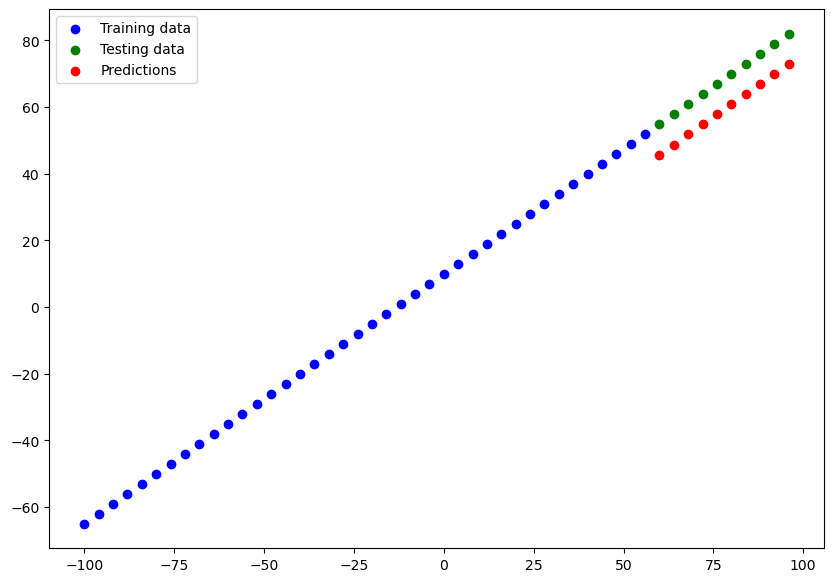

In [25]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)

From the plot we can see our predictions are not too far off the mark.

### Evaluating predictions

Alongisde visualizations, evaulation metrics are your alternative best option for evaluating your model.
Depending on the problem you're working on, different models have different evaluation metrics. 

Two of the main metrics used for regression problems are:
* **Mean absolute error (MAE)** - the mean difference between each of the predictions.
* **Mean squared error (MSE)** - the squared mean difference between of the predictions (use if larger errors are more detrimental than smaller errors).
The lower each of these values, the better.

You can also use [`model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) which will return the loss of the model as well as any metrics setup during the compile step.

In [26]:
# Evaluate the model on the test set
model_2.evaluate(tf.expand_dims(X_test,-1), y_test)

1/1 [==============================] - 0s 108ms/step - loss: 9.1499 - mae: 9.1499 - mse: 83.7249


[9.14991569519043, 9.14991569519043, 83.72490692138672]

In our case, since we used MAE for the loss function as well as MAE for the metrics, `model.evaulate()` returns them both.

TensorFlow also has built in functions for MSE and MAE.
For many evaluation functions, the premise is the same: compare predictions to the ground truth labels.

In [27]:
# Calculate the mean absolute error
mae = tf.metrics.mean_absolute_error(y_true=y_test, 
                                     y_pred=y_preds)
mae

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([22.74833 , 19.726452, 16.704582, 13.682721, 11.228681,  9.383387,
        8.146845,  7.519049,  7.5     ,  8.089697], dtype=float32)>

Shouldn't MAE be a single output? Instead, we get 10 values...

This is because our `y_test` and `y_preds` tensors are different shapes.

In [28]:
# Check the test label tensor values
y_test

array([55., 58., 61., 64., 67., 70., 73., 76., 79., 82.])

In [29]:
# Check the predictions tensor values (notice the extra square brackets)
y_preds

array([[45.75167 ],
       [48.77355 ],
       [51.795418],
       [54.81728 ],
       [57.83915 ],
       [60.861023],
       [63.88289 ],
       [66.904755],
       [69.92662 ],
       [72.94849 ]], dtype=float32)

In [30]:
# Check the tensor shapes
y_test.shape, y_preds.shape

((10,), (10, 1))

Remember how we discussed dealing with different input and output shapes is one the most common issues you'll come across, this is one of those times.
Remember how you can fix it using [`squeeze()`](https://www.tensorflow.org/api_docs/python/tf/squeeze)? 

In [31]:
# To do
# Remove the 1 dimensions from y_preds.


**Solution**

In [32]:
# Shape after squeeze()
y_preds = y_preds.squeeze()
y_preds

array([45.75167 , 48.77355 , 51.795418, 54.81728 , 57.83915 , 60.861023,
       63.88289 , 66.904755, 69.92662 , 72.94849 ], dtype=float32)

Okay, now we know how to make our `y_test` and `y_preds` tenors the same shape, let's use our evaluation metrics.

In [33]:
# Calcuate the MAE
mae = tf.metrics.mean_absolute_error(y_true=y_test, 
                                     y_pred=y_preds)
mae

<tf.Tensor: shape=(), dtype=float32, numpy=9.149916>

In [34]:
# Calculate the MSE
mse = tf.metrics.mean_squared_error(y_true=y_test,
                                    y_pred=y_preds)
mse

<tf.Tensor: shape=(), dtype=float32, numpy=83.72491>

### Running experiments to improve a model

After seeing the evaluation metrics and the predictions your model makes, it's likely you'll want to improve it.

Again, there are many different ways you can do this, but 3 of the main ones are:
1. **Get more data** - get more examples for your model to train on (more opportunities to learn patterns).
2. **Make your model larger (use a more complex model)** - this might come in the form of more layers or more hidden units in each layer.
3. **Train for longer** - give your model more of a chance to find the patterns in the data.

Since we created our dataset, we could easily make more data, but this isn't always the case when you're working with real-world datasets.
Our data is not very realistic in the first place. So, let's create a new dataset and work on that in the next exercise.
But before we actually do the exercise, let's have a look at how to save and load models.

### Saving a model

Once you've trained a model and found one which performs to your liking, you'll probably want to save it for use elsewhere.
You can save a TensorFlow/Keras model using [`model.save()`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model).

There are three ways to save a model in TensorFlow:
1. The [.keras format](https://www.tensorflow.org/tutorials/keras/save_and_load#new_high-level_keras_format) (recommended; use .keras extension).
1. The [SavedModel format](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format) (legacy format; dafault, when no extension is given).
2. The [HDF5 format](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format) (legacy format; use .h5 extension).

"The new Keras v3 saving format, marked by the .keras extension, is a more simple, efficient format that implements name-based saving, ensuring what you load is exactly what you saved, from Python's perspective. This makes debugging much easier, and it is the recommended format for Keras." (source: tensorflow documentation)
The main difference between the two legacy formats is the SavedModel is automatically able to save custom objects (such as special layers) without additional modifications when loading the model back in.

In [35]:
# Save a model using the .keras format
model_2.save('best_model_keras_format.keras')

In [36]:
# Save a model using the HDF5 format
model_2.save("best_model_HDF5_format.h5") # note the addition of '.h5' on the end

/gpfs/opt/sw/jupyterhub/envs/conda/vsc5/jupyterhub-huggingface-v2/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Loading a model

We can load a saved model using the [`load_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) method.

Loading a model for the different formats (.keras, SavedModel and HDF5) is the same.

In [37]:
# Load a model from the SavedModel format
loaded_best_model_keras = tf.keras.models.load_model("./best_model_keras_format.keras")
loaded_best_model_keras.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                20        
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Exercise
Before we continue here, shut down the kernel of this notebook and head to the NN_regression_tensorflow_exercise Notebook build three models and save all of them. We will then load these models into this notebook to compare the results.

### Comparing results

Let's load the models we created during the last exercise. From them, we've got results for 3 similar but slightly different results, let's compare them.

In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [39]:
model_1= tf.keras.models.load_model('./model_1.keras')
model_2= tf.keras.models.load_model('./model_2.keras')
model_3= tf.keras.models.load_model('./model_3.keras')

In [40]:
# Input values of our dataset just as in the exercise NB
X = np.arange(-100, 100, 4)
len(X)

# Target values just as in the exercise NB
y = 0.75*X+5*np.random.randn(len(X), ) # np.random.randn gives us some normally distributed noise
len(y)

# Split data into train and test sets with scikit-learn's train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # test_size 20 %

Let's make functions for our evaluation metrics.

In [41]:
def mae(y_test, y_pred):
  """
  Calculuates mean absolute error between y_test and y_preds.
  """
  return tf.metrics.mean_absolute_error(y_test,
                                        y_pred)
  
def mse(y_test, y_pred):
  """
  Calculates mean squared error between y_test and y_preds.
  """
  return tf.metrics.mean_squared_error(y_test,
                                       y_pred)

In [42]:
y_pred_1 = model_1.predict(tf.expand_dims(X_test,-1))
y_pred_2 = model_2.predict(tf.expand_dims(X_test,-1))
y_pred_3 = model_3.predict(tf.expand_dims(X_test,-1))

1/1 [==============================] - 0s 43ms/step


In [43]:
y_pred_1.shape, y_pred_2.shape, y_pred_3.shape

((10, 1), (10, 1), (10, 1))

In [44]:
y_pred_1 = tf.squeeze(y_pred_1)
y_pred_2 = tf.squeeze(y_pred_2)
y_pred_3 = tf.squeeze(y_pred_3)

In [45]:
mae(y_test, y_pred_1)

<tf.Tensor: shape=(), dtype=float32, numpy=9.526828>

In [46]:
mae_1 = tf.metrics.mean_absolute_error(y_test,y_pred_1).numpy() # reads out just the actual value
mae_2 = tf.metrics.mean_absolute_error(y_test,y_pred_2).numpy()
mae_3 = tf.metrics.mean_absolute_error(y_test,y_pred_3).numpy()

#mse_1 = mse(y_test, y_pred_1).numpy()
#mse_2 = mse(y_test, y_pred_2).numpy()
#mse_3 = mse(y_test, y_pred_3).numpy()

In [47]:
model_results =  [["model_1", mae_1],
                 ["model_2", mae_2],
                 ["model_3", mae_3]]

In [48]:
# Let's have look at how the three different models performed in a Pandas DataFrame:
import pandas as pd
all_results = pd.DataFrame(model_results, columns=["model", "mae"])
all_results

,model,mae
0,model_1,9.526828
1,model_2,14.317319
2,model_3,7.121206


From our experiments, it looks like `model_3` performed the best.